In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error



In [3]:
# Load data =
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Moondash/moondash_data.xlsx', sheet_name='moondash_data')

# Quick EDA
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69000 entries, 0 to 68999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   effective_date    69000 non-null  datetime64[ns]
 1   employee_id       69000 non-null  int64         
 2   job_function      69000 non-null  object        
 3   location          69000 non-null  object        
 4   job_level         69000 non-null  object        
 5   employee_status   69000 non-null  object        
 6   hire_date         69000 non-null  datetime64[ns]
 7   pay_rate_type     69000 non-null  object        
 8   role_volume_type  69000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 4.7+ MB


(None,
   effective_date  employee_id job_function                   location  \
 0     2022-03-31        16041           HR    New York City, New York   
 1     2022-03-31        16449        Sales    New York City, New York   
 2     2022-03-31        15822  Engineering  San Francisco, California   
 3     2022-03-31        15417        Sales  San Francisco, California   
 4     2022-03-31        14944           HR  San Francisco, California   
 
   job_level employee_status  hire_date pay_rate_type role_volume_type  
 0        L5          Active 2020-08-10        Salary              Low  
 1        L6          Active 2020-04-05        Salary              Low  
 2        L4          Active 2021-12-03        Salary              Low  
 3        L5          Active 2021-08-01        Salary              Low  
 4        L4          Active 2021-03-01        Salary              Low  )

In [4]:
display(df)

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
0,2022-03-31,16041,HR,"New York City, New York",L5,Active,2020-08-10,Salary,Low
1,2022-03-31,16449,Sales,"New York City, New York",L6,Active,2020-04-05,Salary,Low
2,2022-03-31,15822,Engineering,"San Francisco, California",L4,Active,2021-12-03,Salary,Low
3,2022-03-31,15417,Sales,"San Francisco, California",L5,Active,2021-08-01,Salary,Low
4,2022-03-31,14944,HR,"San Francisco, California",L4,Active,2021-03-01,Salary,Low
...,...,...,...,...,...,...,...,...,...
68995,2024-12-31,11295,Strategy & Operations,"Orlando, Florida",L3,Active,2024-06-15,Salary,Low
68996,2024-12-31,10773,Strategy & Operations,"Orlando, Florida",L2,Active,2024-03-25,Hourly,High
68997,2024-12-31,14432,Strategy & Operations,"Orlando, Florida",L2,Terminated,2024-12-24,Hourly,High
68998,2024-12-31,12041,Strategy & Operations,"Orlando, Florida",L2,Active,2024-06-29,Hourly,High


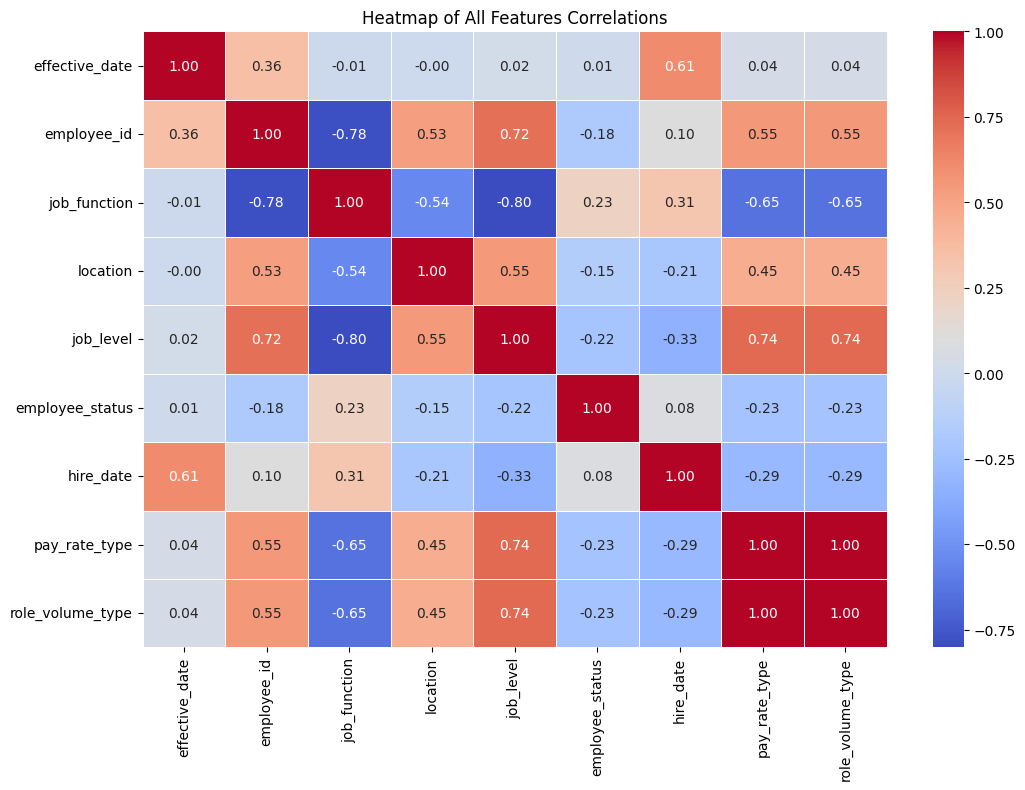

In [5]:


# Convert categorical variables to numeric using label encoding
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Generate feature heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Heatmap of All Features Correlations")
plt.show()

### Key Takeaways from the Heatmap

*   Job function and location are linked – Certain roles, like engineering, could tend to be in tech hubs, while sales jobs are more common in other locations
  - The correlation between job_function and location is -0.54, meaning certain job functions tend to be in specific locations.

*   Higher-level employees are usually salaried – Senior employees are more likely to have salaries, while lower-level roles are often hourly.
 - job_level and pay_rate_type have a high positive correlation (0.74), suggesting that employees in higher positions are more likely salaried.


*   New hires typically start at lower levels – Employees who joined recently are more likely in entry-level positions, while longer-tenured staff have moved up.
 - hire_date has a negative correlation (-0.33) with job_level, meaning employees hired recently are more likely in lower job levels.

*   Some roles have higher turnover – High-volume jobs tend to see more employees leaving compared to specialized roles.

 - job_function and employee_status have a weak positive correlation (0.23), meaning certain job functions have a slightly higher turnover rate.


*   Turnover follows seasonal trends – Employees may leave more often at the
end of quarters or fiscal years, possibly due to layoffs or restructuring.
 - effective_date and hire_date have a moderate correlation (0.61), which may suggest some seasonal hiring/termination trends.


*   Salary depends on location – Employees in certain cities are more likely to have salaried jobs, possibly due to cost of living or industry demand.
 - pay_rate_type and location have a positive correlation (0.45), meaning employees in some locations are more likely salaried.





### Let's take a sample of some unique values, and get a better feel for our dataset

In [6]:
# Summary of unique values and samples
unique_values_summary_samples = {
    "Column": [],
    "Unique Values Count": [],
    "Sample Values": []
}

for col in df.columns:
    unique_values_summary_samples["Column"].append(col)
    unique_values_summary_samples["Unique Values Count"].append(df[col].nunique())

    # 5 unique values as sample values
    sample_values = df[col].dropna().unique()[:5]
    unique_values_summary_samples["Sample Values"].append(", ".join(map(str, sample_values)))

#View in Dataframe
unique_values_samples_df = pd.DataFrame(unique_values_summary_samples)
display(unique_values_samples_df)

,Column,Unique Values Count,Sample Values
0,effective_date,12,"2022-03-31 00:00:00, 2022-06-30 00:00:00, 2022..."
1,employee_id,19297,"16041, 16449, 15822, 15417, 14944"
2,job_function,5,"HR, Sales, Engineering, Finance, Strategy & Op..."
3,location,7,"New York City, New York, San Francisco, Califo..."
4,job_level,9,"L5, L6, L4, L8, L7"
5,employee_status,2,"Active, Terminated"
6,hire_date,1356,"2020-08-10 00:00:00, 2020-04-05 00:00:00, 2021..."
7,pay_rate_type,2,"Salary, Hourly"
8,role_volume_type,2,"Low, High"


It's interesting how there are 19297 unique values in the dataset for employee_id when there are 69000 total rows, let's look deeper

In [7]:
# Check for duplicate records
duplicate_employee_counts = df['employee_id'].value_counts()



### This is odd, considering that these are employee records, there should not be a significant amount of duplicates. Lets do a deeper dive and look into this

In [8]:
# Find employees who appear more than once
num_duplicate_employees = (duplicate_employee_counts > 1).sum()

# Display total number of employees and how many have duplicates
total_unique_employees = df['employee_id'].nunique()
total_records = len(df)


print('Duplicate Employee Count: ', num_duplicate_employees)
print('Unique Employee Count: ', total_unique_employees)
print('Total Records: ', total_records)


Duplicate Employee Count:  13934
Unique Employee Count:  19297
Total Records:  69000


### Lets visualize this and see what it looks like

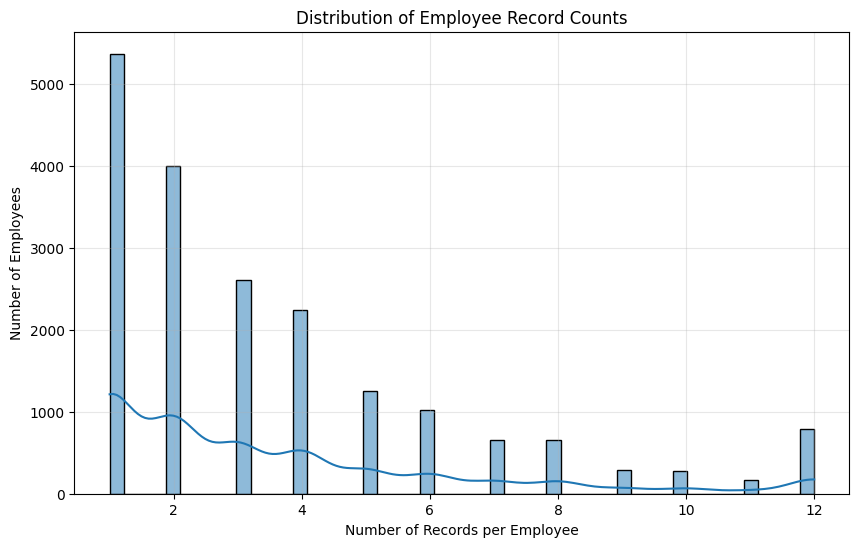

In [9]:
# Plot histogram of record counts per employee
plt.figure(figsize=(10, 6))
sns.histplot(duplicate_employee_counts, bins=50, kde=True)
plt.xlabel("Number of Records per Employee")
plt.ylabel("Number of Employees")
plt.title("Distribution of Employee Record Counts")
plt.grid(alpha=0.3)
plt.show()

### There are several duplicates in this dataset. Lets pick one at random and do a deeper dive. Earlier in the code Employee ID 464 was at the top, let's pick that one.

In [10]:
employee_464_records = df[df['employee_id'] == 464] #Filter for employee 464)

display(employee_464_records)

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
28131,2022-03-31,464,Strategy & Operations,"Orlando, Florida",L2,Active,2020-11-14,Hourly,High
31105,2022-06-30,464,Strategy & Operations,"Orlando, Florida",L2,Active,2020-11-14,Hourly,High
34084,2022-09-30,464,Strategy & Operations,"Orlando, Florida",L2,Active,2020-11-14,Hourly,High
37117,2022-12-31,464,Strategy & Operations,"Orlando, Florida",L2,Active,2020-11-14,Hourly,High
41373,2023-03-31,464,Strategy & Operations,"Orlando, Florida",L2,Active,2020-11-14,Hourly,High
44872,2023-06-30,464,Strategy & Operations,"Orlando, Florida",L3,Active,2020-11-14,Salary,Low
48396,2023-09-30,464,Strategy & Operations,"Orlando, Florida",L3,Active,2020-11-14,Salary,Low
51898,2023-12-31,464,Strategy & Operations,"Orlando, Florida",L3,Active,2020-11-14,Salary,Low
55743,2024-03-31,464,Strategy & Operations,"Orlando, Florida",L3,Active,2020-11-14,Salary,Low
59774,2024-06-30,464,Strategy & Operations,"Orlando, Florida",L3,Active,2020-11-14,Salary,Low


### This answers that question. In the data dictionary, eﬀective_date is defined as 'Date employee data was recorded'. The fact that there are multiple duplicates, and by looking at the data, you can see that this means that these records are pulled on a three month cadence, so having duplicates is completely normal. This is also helpful, because I also know I can calculate promotions now.


### From above, it looks like 'role_volume_type' and 'pay_rate_type' have the exact same distrubutions. Lets take a deeper look.


In [11]:
#Counts of unique values for role_volume_type and pay_rate_type
unique_role_volume_counts = df["role_volume_type"].value_counts()
unique_pay_rate_counts = df["pay_rate_type"].value_counts()

print(unique_role_volume_counts)
print(unique_pay_rate_counts)



role_volume_type
Low     39084
High    29916
Name: count, dtype: int64
pay_rate_type
Salary    39084
Hourly    29916
Name: count, dtype: int64


### So it looks like, they have the exact same values and distrubution. As a sanity check, let's see if any records have a role_volume_type of Low and a pay_rate_type of High


In [12]:
test_filtered_df = df[(df["role_volume_type"] == "Low") & (df["pay_rate_type"] == "High")]
display(test_filtered_df)

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type


### This means that the two columns are exact duplicates. This is good to know as we proceed that there might be some discrepencies later on.

In [13]:
#Most recent record for each employee
latest_status_df = df.sort_values(by="effective_date").drop_duplicates(subset="employee_id", keep="last")

#Turnover Rate calculation
total_employees = latest_status_df['employee_id'].nunique()
terminated_employees = latest_status_df[latest_status_df['employee_status'] == 'Terminated']['employee_id'].nunique()
turnover_rate_corrected = terminated_employees / total_employees


print(f"Terminated Employees: {terminated_employees}")
print(f"Total Employees: {total_employees}")
print(f"Turnover Rate: {turnover_rate_corrected:.2%}")


Terminated Employees: 14206
Total Employees: 19297
Turnover Rate: 73.62%


### Let's calculate how many promotions occured each year now too. We will identify promotion as when job_level increases compared to the previous record for the same employee

In [14]:
df_copy = df.copy()
df_copy['effective_date'] = pd.to_datetime(df_copy['effective_date']) #Converting to datetime

# Sort by employee_id and effective_date to track promotions over time
df_copy = df_copy.sort_values(by=['employee_id', 'effective_date'])

# Identify promotions:
df_copy['previous_job_level'] = df_copy.groupby('employee_id')['job_level'].shift(1)

# Convert to numeric
df_copy['job_level_numeric'] = df_copy['job_level'].str.extract('(\d+)').astype(float)
df_copy['previous_job_level_numeric'] = df_copy['previous_job_level'].str.extract('(\d+)').astype(float)

# Aggregating promotions into new dataframe column
df_copy['promotion'] = df_copy['job_level_numeric'] > df_copy['previous_job_level_numeric']
df_copy['year'] = df_copy['effective_date'].dt.year

# Count promotions per year
promotions_per_year = df_copy[df_copy['promotion']].groupby('year').size().reset_index(name='promotion_count')


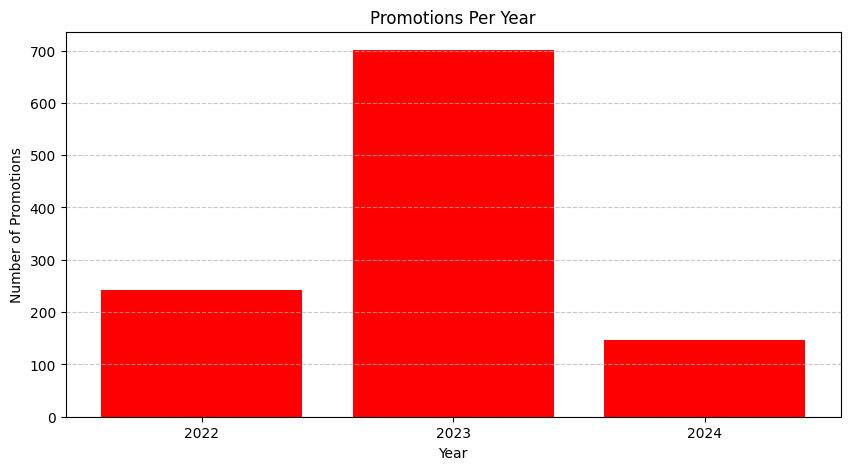

In [15]:
# Visualization
plt.figure(figsize=(10, 5))
plt.bar(promotions_per_year['year'], promotions_per_year['promotion_count'], color='red')
plt.xlabel('Year')
plt.ylabel('Number of Promotions')
plt.title('Promotions Per Year')
plt.xticks(promotions_per_year['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### It looks like in 2023, there were a significant amount of promotions in 2023 compared to other years

Earliest Hire Date: 2018-01-03 00:00:00
Latest Hire Date: 2024-12-31 00:00:00
Average Tenure: 403.28079710144925 Days


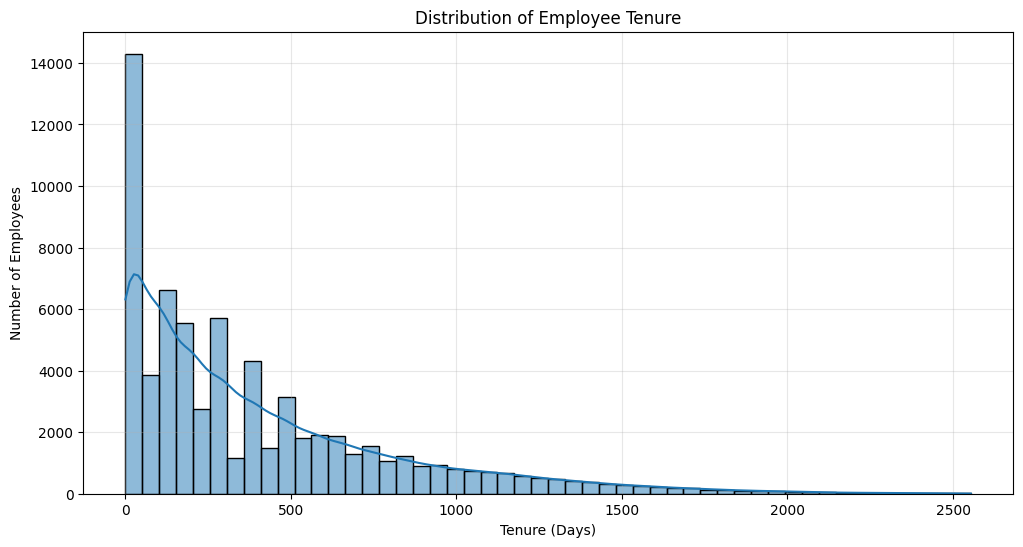

In [16]:
#Earliest hire
earliest_hire_date = df["hire_date"].min()
latest_hire_data = df["hire_date"].max()

print(f"Earliest Hire Date: {earliest_hire_date}")
print(f"Latest Hire Date: {latest_hire_data}")

# Average tenure before termination
df['tenure_days'] = (df['effective_date'] - df['hire_date']).dt.days
average_tenure_days = df["tenure_days"].mean()
print('Average Tenure:', average_tenure_days, 'Days')

# Plot the distribution of tenure days
plt.figure(figsize=(12, 6))
sns.histplot(df["tenure_days"], bins=50, kde=True)
plt.xlabel("Tenure (Days)")
plt.ylabel("Number of Employees")
plt.title("Distribution of Employee Tenure")
plt.grid(alpha=0.3)
plt.show()


### This suggests that a large proportion of employees have left the company at some point, or that the dataset includes a lot of short-term employees. The data also only starts in 2018, so this only covers employees from the last 6-7 years which. If there is a large concentration of employees with a short tenure (about a year or two), this could be why there is such a high turnover.

In [17]:
###Turnover Rate by Year

# Extract hire year
df["hire_year"] = df["hire_date"].dt.year

# Turnover rate per hire year
turnover_by_hire_year = df[df["employee_status"] == "Terminated"].groupby("hire_year")["employee_id"].nunique() / df.groupby("hire_year")["employee_id"].nunique()

# Convert to df
turnover_by_hire_year_df = turnover_by_hire_year.reset_index()
turnover_by_hire_year_df.columns = ["Hire Year", "Turnover Rate"]


### Hiring Amount by Year

# Count number of hires per year
hires_per_year = df.groupby("hire_year")["employee_id"].nunique().reset_index()
hires_per_year.columns = ["Hire Year", "Number of Hires"]

### Termination Amount by Year

# Count number of terminations per year
terminations_per_year = df[df["employee_status"] == "Terminated"].groupby("hire_year")["employee_id"].nunique().reset_index()
terminations_per_year.columns = ["Hire Year", "Number of Terminations"]





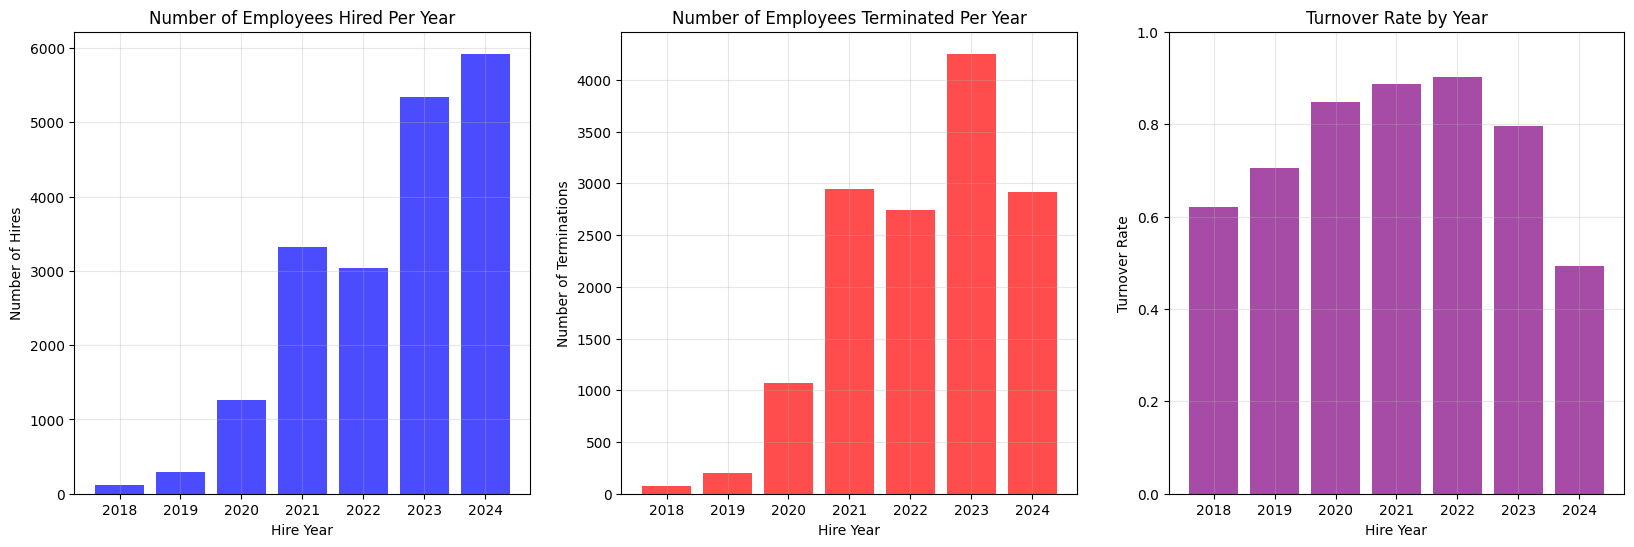

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot hires per year
axes[0].bar(hires_per_year["Hire Year"], hires_per_year["Number of Hires"], color="blue", alpha=0.7)
axes[0].set_title("Number of Employees Hired Per Year")
axes[0].set_xlabel("Hire Year")
axes[0].set_ylabel("Number of Hires")
axes[0].grid(alpha=0.3)

# Plot terminations per year
axes[1].bar(terminations_per_year["Hire Year"], terminations_per_year["Number of Terminations"], color="red", alpha=0.7)
axes[1].set_title("Number of Employees Terminated Per Year")
axes[1].set_xlabel("Hire Year")
axes[1].set_ylabel("Number of Terminations")
axes[1].grid(alpha=0.3)

# Plot turnover rate by year
axes[2].bar(turnover_by_hire_year_df["Hire Year"], turnover_by_hire_year_df["Turnover Rate"], color="purple", alpha=0.7)
axes[2].set_title("Turnover Rate by Year")
axes[2].set_xlabel("Hire Year")
axes[2].set_ylabel("Turnover Rate")
axes[2].set_ylim(0, 1)
axes[2].grid(alpha=0.3)


plt.show()

### Key Takeaways from looking at Hiring, Terminations, and Turnover


*   2024 shows the lowest turnover so far, which could show it is moving in a good direction as Moondash starts to stablize a bit with hiring and termination practices.

*   The termination count spiked in 2021 and 2023, suggesting a higher turnover rate, maybe from something like restructuring or layoffs.

*   There was a signficant rise in hiring after 2020: Hiring surged significantly in 2021, 2022, and 2023, with a peak in 2023-2024. This could suggest the company starting to stablize after COVID-19.

*   2021-2023 had both high hiring and termination rates which could mean possible company expansion but a struggle with employee retention.




### In the above text, we did some exploratory data analysis by year. Now let's look at some other categories

In [19]:
#Compute turnover by the different categories
def calculate_turnover_rate(column):
    terminated_counts = df[df['employee_status'] == 'Terminated'].groupby(column)['employee_id'].count() # Number of terminated employees in each group
    total_counts = df.groupby(column)['employee_id'].count() #Total number of employees in each group
    turnover_rate = terminated_counts / total_counts # Compute the turnover rate
    return turnover_rate


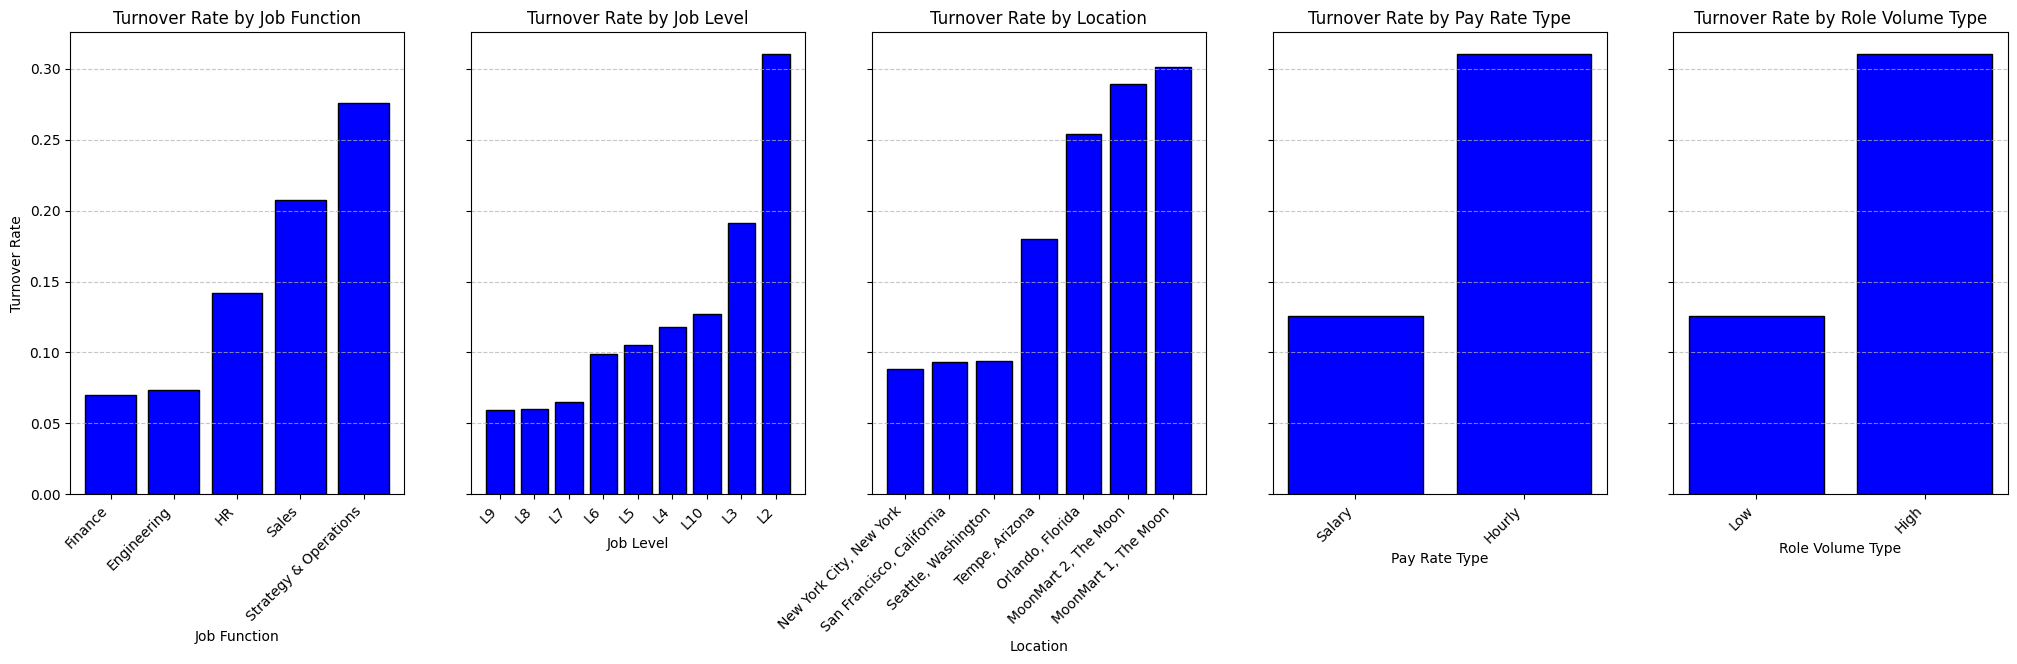

In [20]:
# Defining categories and titles for plots
turnover_data = {
    "Job Function": calculate_turnover_rate('job_function'),
    "Job Level": calculate_turnover_rate('job_level'),
    "Location": calculate_turnover_rate('location'),
    "Pay Rate Type": calculate_turnover_rate('pay_rate_type'),
    "Role Volume Type": calculate_turnover_rate('role_volume_type'),
}



#Create template for plots
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)


# Plotting each turnover
for ax, (label, data) in zip(axes, turnover_data.items()):
    sorted_data = data.sort_values()
    ax.bar(sorted_data.index, sorted_data.values, color='blue', edgecolor='black')
    ax.set_title(f"Turnover Rate by {label}")
    ax.set_xlabel(label)
    ax.set_xticklabels(sorted_data.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[0].set_ylabel("Turnover Rate")


plt.show()


In [21]:
print(turnover_data)

{'Job Function': job_function
Engineering              0.073551
Finance                  0.069795
HR                       0.141779
Sales                    0.207447
Strategy & Operations    0.276000
Name: employee_id, dtype: float64, 'Job Level': job_level
L10    0.126904
L2     0.310269
L3     0.191162
L4     0.117629
L5     0.105190
L6     0.099020
L7     0.065353
L8     0.060276
L9     0.059271
Name: employee_id, dtype: float64, 'Location': location
MoonMart 1, The Moon         0.301147
MoonMart 2, The Moon         0.289469
New York City, New York      0.088462
Orlando, Florida             0.253787
San Francisco, California    0.093502
Seattle, Washington          0.094065
Tempe, Arizona               0.180014
Name: employee_id, dtype: float64, 'Pay Rate Type': pay_rate_type
Hourly    0.310269
Salary    0.125985
Name: employee_id, dtype: float64, 'Role Volume Type': role_volume_type
High    0.310269
Low     0.125985
Name: employee_id, dtype: float64}



### Key Takeaways from looking at categories of data



*   Turnover is highest in lower-level jobs like L2 and L3, which could mean challenges with career growth or workload.

*   Hourly employees have a much higher turnover rate than salaried employees.


*   Certain locations have significantly higher turnover, which could be due to market conditions, cost of living, or industry norms. For example MoonMart 1 and MoonMart2 have the highest turnover rates, which could suggest employees would rather stay on Earth.


*   High-volume roles experience more turnover, likely because these positions involve repetitive or less specialized work.

